# Workflow for "Urban highways are barriers for social ties"

Before running the notebook, provide settings in `./code/config.yml`:

* `dist`: "beeline" (or "walking") 
* `density`: 1 (or 0)
* `rand_layout`: 0 (or 1)
* `seed`: 42 (or any other integer)
* `cbsa`: 16980 (one of: 12420, 16980, 33100, 38300, 38900)

**Note:** make sure to choose the correct setting for `rand_layout`: 
* `rand_layout=0` will download *only* motorway data (~20 min runtime, ~MB data downloaded)
* `rand_layout=1` will download *all* street network data (~several h runtime, ~GB data downloaded)

The notebook will then run the workflow necessary to reproduce all major results and plots from the research paper [Urban highways are barriers for social ties](https://arxiv.org/abs/2404.11596). 

**Note:** due to privacy concerns, instead of providing the real Twitter data that informed the research paper, we run the entire workflow with randomly generated Twitter data (in the same format, but not containing any information from the original data set). This random data set has been generated within the notebook `00_randomize_twitter.ipynb`. 

In [1]:
import warnings
warnings.filterwarnings("ignore")
import os
import sys
import argparse
import random
from time import time
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import LineString, Point, MultiPoint, MultiLineString, Polygon
from tqdm import tqdm
from geopy.distance import distance, geodesic, great_circle
import osmnx as ox
import networkx as nx
import scipy.stats
from scipy.stats import ks_2samp
import sklearn
import igraph
from igraph import Graph

from random import choice
from bisect import bisect_left
import copy

from functools import partial
import pyproj
from pyproj import Geod
from pyproj.crs import ProjectedCRS
from pyproj.crs.coordinate_operation import AzimuthalEquidistantConversion
from shapely.ops import transform

import yaml
from utils import *

In [2]:
# set plot params
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['font.size'] = 15

In [3]:
# set OSM highway tags
motorway_osm_labels = ['motorway', 'trunk', 'motorway_link', 'trunk_link']
motorway_osm_filter = "['highway'~'motorway|motorway_link|trunk|trunk_link']"

In [4]:
# create subfolders for output data
for sub in [
    "../data/street_networks_simplified/",
    "../data/social_networks/",
    "../data/social_networks_null/",
    "../data/error_logs/",
    "../plots/",
    "../results/",
    "../results_walking/",
]:
    os.makedirs(sub, exist_ok=True)

In [5]:
# load params from config file (instead of command line args)
config = yaml.load(
    open("config.yml"), 
    Loader=yaml.FullLoader
    )

# check whether parameters are correctly set in config file
check_configs(config)

Config file filled out correctly, proceeding


In [ ]:
# Gather parameters from config file
beeline = config["dist"] 
density = config["density"]
rand_layout = config["rand_layout"]
seed = config["seed"]
cbsacode = config["cbsa"]

distance_type = config["dist"] if config["dist"] is not None else 'beeline'  # beeline|walking: impacts how n-distance neighbors are selected
filter_by_density = bool(int(config["density"])) if config["density"] is not None else True # preferential attachment based on density
randomize_streets = int(config["rand_layout"]) if config["rand_layout"] is not None else 0 # whether the street layout should be randomized
random_seed = int(config["seed"]) if config["seed"] is not None else 42 # the random seed for computation
print(
    f'Parameters: cbsacode={cbsacode}, distance_type={distance_type}, filter_by_density={filter_by_density}, randomize_streets={randomize_streets}, random_seed={random_seed}', 
    flush=True
)

# set seed
random.seed(random_seed)

In [6]:
gdf_cbsacodes = gpd.read_file('../data/twitter_dummy/cbsacode_random.gpkg')
nodes_gpkg = '../data/twitter_dummy/twitter_users_tract_random.gpkg'
edges_gpkg = '../data/twitter_dummy/twitter_follower_edges_random.gpkg'

In [7]:
target_city = gdf_cbsacodes[gdf_cbsacodes['cbsacode'] == cbsacode]
city_name = target_city['name'].values[0]
city_boundaries = target_city["geometry"].values[0]
print(f'Target city {city_name}')
print(f'RANDOM SEED {random_seed}', flush=True)
print(f'Ranomize streets = {randomize_streets}', flush=True)

Target city Chicago
RANDOM SEED 42
Ranomize streets = 0


### Null model computation

In [8]:
### Download and save OSM data

folder_osm = "../data/street_networks_simplified/"

# determining whether to download all streets (for randomization; big dataset)
# or only highways (if no randomization is requested)
if randomize_streets:
    custom_filter = None
    dataset = "allprivate"
else:
    custom_filter = motorway_osm_filter
    dataset = "highways"

if os.path.exists(folder_osm + f'{cbsacode}_G_simplified_{dataset}.graphml'):
    print("loading OSM data...")
    G = ox.load_graphml(folder_osm + f'{cbsacode}_G_simplified_{dataset}.graphml')
    with open(folder_osm + f'{cbsacode}_streetnodes_{dataset}.pickle', 'rb') as handle:
        gdf_nodes_city = pickle.load(handle)
    with open(folder_osm +  f'{cbsacode}_streetedges_{dataset}.pickle', 'rb') as handle:
        gdf_edges_city = pickle.load(handle)
    print(f'{cbsacode} street graph for {dataset} loaded from file', flush=True)
else:
    print("downloading OSM data...")
    G, gdf_nodes_city, gdf_edges_city = get_street_network(
        cbsacode=cbsacode,
        polygon=city_boundaries,
        customfilter=custom_filter,
        dataset=dataset,
        savetofolder=folder_osm,
    )
    print(f'{cbsacode} DONE', flush=True)

downloading OSM data...
Applying custom filter: ['highway'~'motorway|motorway_link|trunk|trunk_link']
OSM data downloaded for 16980
OSM data simplified
Saving G_simplified...
Saving gdfs...
16980 DONE


In [9]:
# create street graph
G_igraph = convert_nxgraph_to_igraph(G)

In [10]:
### Load and filter social data

is_undirected = False # used in configuration_model_spatial_constraint()

try:
    gdf_nodes = gpd.read_parquet(f'../data/social_networks/{cbsacode}_gdf_nodes.pq')
    gdf_edges = gpd.read_parquet(f'../data/social_networks/{cbsacode}_gdf_edges.pq')
    print(f'{cbsacode} social graph loaded from file', flush=True)

except:
    # get dataframes of nodes and edges of the social network
    gdf_nodes, gdf_edges = get_city_geodataframes(
        nodes_gpkg, 
        edges_gpkg, 
        cbsacode, 
        city_boundaries = gdf_cbsacodes[gdf_cbsacodes["cbsacode"]==cbsacode]["geometry"].values[0]
    )

    # pre-process social nodes dataframe
    gdf_nodes = calculate_social_nodes_density(
        gdf_nodes, 
        radius_m=400
    )

    gdf_nodes = calculate_closest_street_nodes_to_social_nodes(
        gdf_nodes, 
        G
    )

    # pre-process social edges dataframe
    gdf_edges = calculate_social_edges_distances(
        G_igraph, 
        gdf_nodes_city, 
        gdf_nodes, 
        gdf_edges, 
        ignore_walking=True
    )

    # removes nodes and edges with null distance
    all_rows = len(gdf_edges)
    gdf_edges = gdf_edges.dropna()
    print(f'{cbsacode} removed {all_rows - len(gdf_edges)} edges with null distance')

    gdf_nodes = gdf_nodes[(gdf_nodes['user_id'].isin(gdf_edges['user_id1'])) | (gdf_nodes['user_id'].isin(gdf_edges['user_id2']))]

    # save augmented dataframes on parquet
    gdf_nodes.to_parquet(f'../data/social_networks/{cbsacode}_gdf_nodes.pq')
    gdf_edges.to_parquet(f'../data/social_networks/{cbsacode}_gdf_edges.pq')
    print(f'{cbsacode} social graph files created', flush=True)


Filtering to city_boundaries -- nodes: 1000->1000 | edges: 2500->2500
removing 0 edges with zero-distance
16980 removed 0 edges with null distance
16980 social graph files created


In [11]:
# safety check to filter out nodes without a tract assigned to them
gdf_users = gpd.read_file(nodes_gpkg).dropna()
gdf_nodes = gdf_nodes[gdf_nodes['user_id'].isin(gdf_users['user_id'])]
gdf_edges = gdf_edges[(gdf_edges['user_id1'].isin(gdf_users['user_id'])) & (gdf_edges['user_id2'].isin(gdf_users['user_id']))]

In [12]:
### Null model
gdf_edges_null_filename = get_filename_CM_edges(
    cbsacode,
    distance_type,
    filter_by_density,
    random_seed   
)

err_logs_filename = get_filename_CM_logs(
    cbsacode,
    distance_type,
    filter_by_density,
    random_seed
)

try:

    gdf_edges_null = gpd.read_parquet(gdf_edges_null_filename)
    
    with open(err_logs_filename, 'rb') as handle:
        err_logs = pickle.load(handle)
    
    dist_error_log = err_logs['dist_error_log']
    dist_error_perc_log = err_logs['dist_error_perc_log']
    tolerance_log = err_logs['tolerance_log']
    print(f'{cbsacode} null model loaded from file', flush=True)

except:

    print(f'{cbsacode} computing null model from scratch', flush=True)
    res = configuration_model_spatial_constraint(
        gdf_edges, 
        gdf_nodes, 
        G, 
        G_igraph, 
        gdf_nodes_city, 
        cbsacode, 
        city_boundaries = city_boundaries,
        distance_type=distance_type, 
        filter_by_density=filter_by_density, 
        calculate_walking_on_selected = False, 
        undirected=is_undirected,
        test_mode=False, 
        random_seed=random_seed
        )
    
    gdf_edges_null, dist_error_log, dist_error_perc_log, tolerance_log = res
    print(f'{cbsacode} null model calculated', flush=True)

if distance_type == 'beeline':
    gdf_edges_null['distance_walking_m'] = 0
    gdf_edges_null['geometry_walking'] = 0

16980 computing null model from scratch
== 925 2500


396it [00:50,  8.50it/s]

**, 590.3897845407428


440it [00:54,  9.14it/s]

**, 590.3897845407428


999it [02:00, 10.94it/s]

1000 edges parsed (0 cache hits)
--- 677 1503


1477it [03:02,  6.89it/s]

**, 590.3897845407428


1517it [03:08,  6.43it/s]

**, 590.3897845407428


1518it [03:08,  4.07it/s]

**, 590.3897845407428


1679it [03:30,  5.99it/s]

**, 590.3897845407428


1714it [03:36,  9.15it/s]

**, 590.3897845407428


1721it [03:38,  6.04it/s]

**, 590.3897845407428


1762it [03:44,  6.03it/s]

**, 590.3897845407428


1765it [03:44,  5.91it/s]

**, 590.3897845407428


1788it [03:48,  7.80it/s]

**, 590.3897845407428


1829it [03:53,  8.18it/s]

**, 590.3897845407428


1846it [03:55,  8.66it/s]

**, 590.3897845407428


1853it [03:56,  7.94it/s]

**, 590.3897845407428


1868it [03:58,  7.66it/s]

**, 590.3897845407428


1905it [04:03, 10.00it/s]

**, 590.3897845407428


1909it [04:04,  4.37it/s]

**, 590.3897845407428


1931it [04:08,  9.60it/s]

**, 590.3897845407428


1938it [04:09,  9.34it/s]

**, 590.3897845407428


1972it [04:13,  9.20it/s]

**, 590.3897845407428


1978it [04:14,  7.83it/s]

**, 590.3897845407428


1999it [04:17,  8.34it/s]

2000 edges parsed (0 cache hits)
--- 303 522


2014it [04:20,  8.07it/s]

**, 590.3897845407428


2020it [04:21,  4.87it/s]

**, 590.3897845407428


2023it [04:22,  5.23it/s]

**, 590.3897845407428


2024it [04:22,  4.42it/s]

**, 590.3897845407428


2029it [04:23,  5.91it/s]

**, 590.3897845407428


2044it [04:25,  7.12it/s]

**, 590.3897845407428


2052it [04:26,  6.57it/s]

**, 590.3897845407428


2062it [04:28,  7.29it/s]

**, 590.3897845407428


2063it [04:28,  5.06it/s]

**, 590.3897845407428


2071it [04:29,  6.76it/s]

**, 590.3897845407428


2074it [04:30,  5.92it/s]

**, 590.3897845407428


2082it [04:31,  7.51it/s]

**, 590.3897845407428


2083it [04:31,  5.66it/s]

**, 590.3897845407428


2092it [04:33,  4.69it/s]

**, 590.3897845407428


2103it [04:35,  7.05it/s]

**, 590.3897845407428


2108it [04:36,  7.40it/s]

**, 590.3897845407428


2128it [04:39,  5.93it/s]

**, 590.3897845407428


2135it [04:40,  7.38it/s]

**, 590.3897845407428


2146it [04:42,  7.01it/s]

**, 590.3897845407428


2159it [04:43,  8.90it/s]

**, 590.3897845407428


2161it [04:44,  7.25it/s]

**, 590.3897845407428


2179it [04:46,  6.57it/s]

**, 590.3897845407428


2186it [04:48,  5.73it/s]

**, 590.3897845407428


2187it [04:48,  4.75it/s]

**, 590.3897845407428


2194it [04:49,  5.72it/s]

**, 590.3897845407428


2196it [04:50,  5.12it/s]

**, 590.3897845407428


2201it [04:51,  5.83it/s]

**, 590.3897845407428


2207it [04:52,  6.92it/s]

**, 590.3897845407428


2222it [04:54,  7.44it/s]

**, 590.3897845407428


2229it [04:55,  8.00it/s]

**, 590.3897845407428


2230it [04:55,  5.70it/s]

**, 590.3897845407428


2231it [04:56,  4.69it/s]

**, 590.3897845407428


2232it [04:56,  4.12it/s]

**, 590.3897845407428


2235it [04:56,  4.69it/s]

**, 590.3897845407428


2240it [04:58,  5.12it/s]

**, 590.3897845407428


2243it [04:58,  5.84it/s]

**, 590.3897845407428


2245it [04:59,  4.59it/s]

**, 590.3897845407428


2246it [04:59,  4.09it/s]

**, 590.3897845407428


2258it [05:01,  7.37it/s]

**, 590.3897845407428


2264it [05:02,  6.38it/s]

**, 590.3897845407428


2270it [05:03,  5.46it/s]

**, 590.3897845407428


2271it [05:03,  4.61it/s]

**, 590.3897845407428


2273it [05:04,  3.96it/s]

**, 590.3897845407428


2278it [05:05,  5.70it/s]

**, 590.3897845407428


2283it [05:06,  5.63it/s]

**, 590.3897845407428


2292it [05:07,  6.14it/s]

**, 590.3897845407428


2295it [05:08,  5.85it/s]

**, 590.3897845407428


2298it [05:09,  4.31it/s]

**, 590.3897845407428


2306it [05:10,  5.45it/s]

**, 590.3897845407428


2312it [05:11,  5.35it/s]

**, 590.3897845407428


2314it [05:12,  4.50it/s]

**, 590.3897845407428


2316it [05:13,  3.44it/s]

**, 590.3897845407428


2322it [05:14,  5.31it/s]

**, 590.3897845407428


2330it [05:15,  5.73it/s]

**, 590.3897845407428


2332it [05:16,  5.26it/s]

**, 590.3897845407428


2348it [05:18,  8.19it/s]

**, 590.3897845407428


2351it [05:19,  6.97it/s]

**, 590.3897845407428


2353it [05:19,  5.76it/s]

**, 590.3897845407428


2354it [05:19,  4.70it/s]

**, 590.3897845407428


2355it [05:20,  4.19it/s]

**, 590.3897845407428


2357it [05:20,  4.51it/s]

**, 590.3897845407428


2361it [05:21,  4.90it/s]

**, 590.3897845407428


2363it [05:22,  4.17it/s]

**, 590.3897845407428


2364it [05:22,  3.73it/s]

**, 590.3897845407428


2365it [05:22,  3.49it/s]

**, 590.3897845407428


2366it [05:23,  3.35it/s]

**, 590.3897845407428


2367it [05:23,  3.30it/s]

**, 590.3897845407428


2375it [05:24,  6.80it/s]

**, 590.3897845407428


2377it [05:25,  5.53it/s]

**, 590.3897845407428


2379it [05:25,  3.88it/s]

**, 590.3897845407428


2380it [05:26,  3.51it/s]

**, 590.3897845407428


2382it [05:26,  4.00it/s]

**, 590.3897845407428


2383it [05:26,  3.64it/s]

**, 590.3897845407428


2384it [05:27,  3.23it/s]

**, 590.3897845407428


2392it [05:28,  5.84it/s]

**, 590.3897845407428


2394it [05:29,  5.39it/s]

**, 590.3897845407428


2398it [05:30,  5.71it/s]

**, 590.3897845407428


2401it [05:30,  5.74it/s]

**, 590.3897845407428


2403it [05:31,  4.64it/s]

**, 590.3897845407428


2404it [05:31,  4.11it/s]

**, 590.3897845407428


2405it [05:31,  3.75it/s]

**, 590.3897845407428


2408it [05:32,  5.16it/s]

**, 590.3897845407428


2411it [05:32,  5.14it/s]

**, 590.3897845407428


2414it [05:33,  5.47it/s]

**, 590.3897845407428


2422it [05:34,  8.46it/s]

**, 590.3897845407428


2425it [05:35,  4.34it/s]

**, 590.3897845407428


2434it [05:37,  5.81it/s]

**, 590.3897845407428


2436it [05:37,  5.61it/s]

**, 590.3897845407428


2439it [05:38,  4.64it/s]

**, 590.3897845407428


2440it [05:38,  3.85it/s]

**, 590.3897845407428


2441it [05:39,  3.65it/s]

**, 590.3897845407428


2446it [05:40,  4.60it/s]

**, 590.3897845407428


2452it [05:41,  4.46it/s]

**, 590.3897845407428


2455it [05:42,  5.01it/s]

**, 590.3897845407428


2457it [05:42,  4.79it/s]

**, 590.3897845407428


2462it [05:43,  4.83it/s]

**, 590.3897845407428


2463it [05:44,  4.14it/s]

**, 590.3897845407428


2468it [05:44,  6.41it/s]

**, 590.3897845407428


2470it [05:45,  4.71it/s]

**, 590.3897845407428


2471it [05:45,  4.08it/s]

**, 590.3897845407428


2472it [05:46,  3.64it/s]

**, 590.3897845407428


2474it [05:46,  3.80it/s]

**, 590.3897845407428


2480it [05:47,  5.24it/s]

**, 590.3897845407428


2481it [05:48,  4.52it/s]

**, 590.3897845407428


2484it [05:48,  5.27it/s]

**, 590.3897845407428


2486it [05:49,  5.17it/s]

**, 590.3897845407428


2492it [05:50,  6.34it/s]

**, 590.3897845407428


2493it [05:50,  5.13it/s]

**, 590.3897845407428


2495it [05:51,  3.99it/s]

**, 590.3897845407428


2496it [05:51,  3.76it/s]

**, 590.3897845407428


2497it [05:51,  3.60it/s]

**, 590.3897845407428


2500it [05:52,  7.09it/s]

remaining stubs: 132
cache hits: 0
16980 null model calculated


Real social graph: N=[997], E=2500 | Null social graph: E=2374
16980 sequence test: {'indegree': KstestResult(statistic=0.029855012792988855, pvalue=0.788821185181196, statistic_location=3, statistic_sign=-1), 'outdegree': KstestResult(statistic=0.03566310673031303, pvalue=0.591564787116244, statistic_location=2, statistic_sign=-1)}
16980 error test: {'error_meters': (97.62246621621621, 73.0), 'error_perc': (0.001359200014965422, 0.0009961483576637741), 'error_tolerance': (nan, nan)}
16980 distance test: {'beeline': KstestResult(statistic=0.0029486099410278013, pvalue=0.9999999999999998, statistic_location=95277, statistic_sign=-1)}


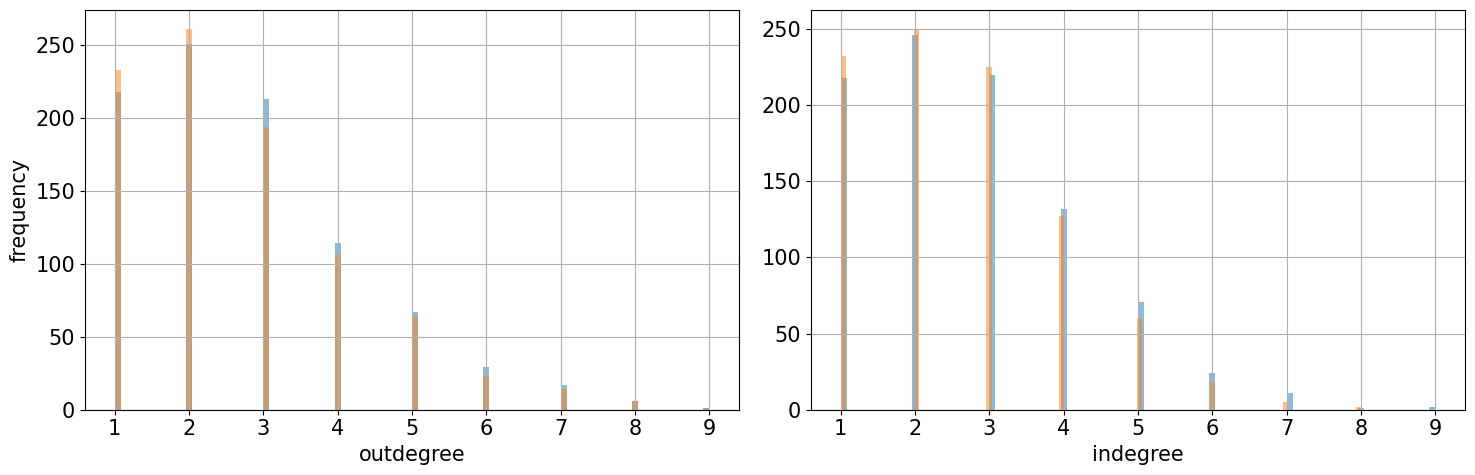

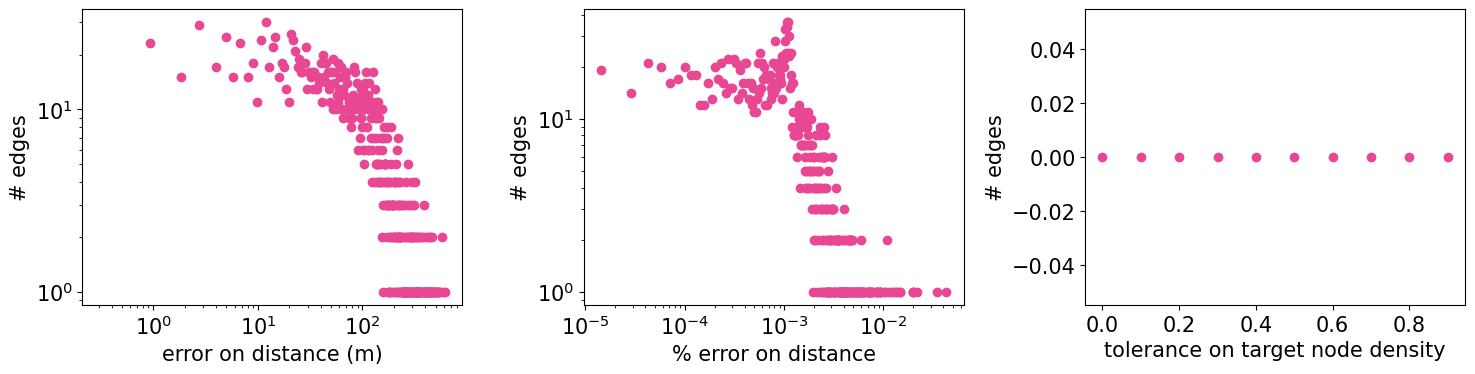

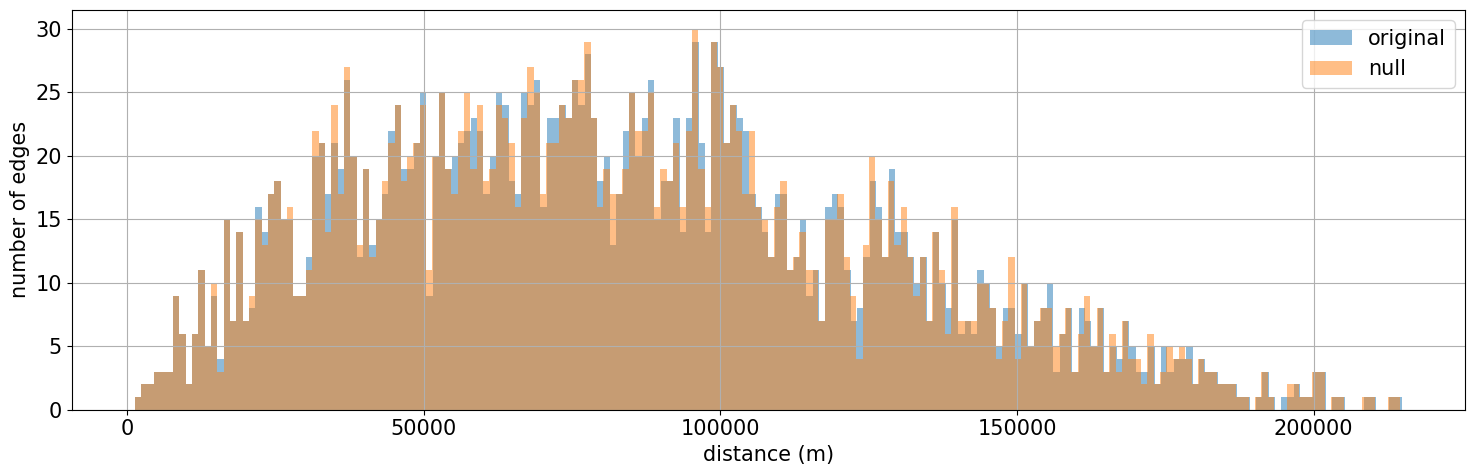

In [13]:
#### Sanity checks for null model

outfolder_plots = "../plots/"

print(f'Real social graph: N={[len(gdf_nodes)]}, E={len(gdf_edges)} | Null social graph: E={len(gdf_edges_null)}', flush=True)

sequence_test = sanity_degree_sequence(
    gdf_edges, 
    gdf_edges_null, 
    cbsacode, 
    plot=True, 
    save=not os.path.exists(outfolder_plots + f"{cbsacode}_sanity1.png"), 
    outfolder_plots=outfolder_plots
    )
print(f'{cbsacode} sequence test: {sequence_test}', flush=True)

errors_test = sanity_errors(
    dist_error_log, 
    dist_error_perc_log, 
    tolerance_log, 
    cbsacode,
    plot=True, 
    save=not os.path.exists(outfolder_plots + f"{cbsacode}_sanity2.png"), 
    outfolder_plots=outfolder_plots    
    )
print(f'{cbsacode} error test: {errors_test}', flush=True)

distance_test = sanity_distance_distribution(
    gdf_edges_null, 
    cbsacode,
    plot=True, 
    save=not os.path.exists(outfolder_plots + f"{cbsacode}_sanity3.png"), 
    outfolder_plots=outfolder_plots
    )
print(f'{cbsacode} distance test: {distance_test}', flush=True)

In [14]:
def plot_street_network(
        gdf_edges_city, 
        cbsacode, 
        outfolder_plots = "../plots/"
    ):
    
    # plotting the street network
    street_types = ['motorway', 'trunk', 'primary', 'secondary', 'tertiary', 'residential']
    colors = ['#C33478', '#C33478', '#CF6F3B', '#90b7f2', '#90b7f2', 'gray']
    width = [3, 3, 2, 0.8, 0.8, 0.3]
    alpha = [0.5, 0.5, 0.5, 0.5, 0.5, 0.2]
    i = len(street_types)
    fig, ax = plt.subplots(1,1, figsize=(15,15))
    for street_type, c , w, a  in zip(street_types, colors, width, alpha):
        df_selection = gdf_edges_city[gdf_edges_city['highway']==street_type]
        if len(df_selection)>0: # plot street types if they exist 
            df_selection = gpd.GeoDataFrame(df_selection, geometry=df_selection['geometry'], crs='epsg:4326')
            df_selection.plot(lw=w, color=c, alpha=a, ax=ax, label=street_type, zorder = i)
            i -= 1
    fig.patch.set_facecolor('#f3ebd5')
    ax.legend()
    #gdf_nodes_bb.plot(markersize=2, color='yellow', alpha=0.3, ax=ax)
    #gdf_edges.plot(lw=0.1, color='white', alpha=0.1, ax=ax)
    ax.axis('off')
    plt.tight_layout()
    plt.savefig(outfolder_plots + f'{cbsacode}_streetmap.png', dpi=800)


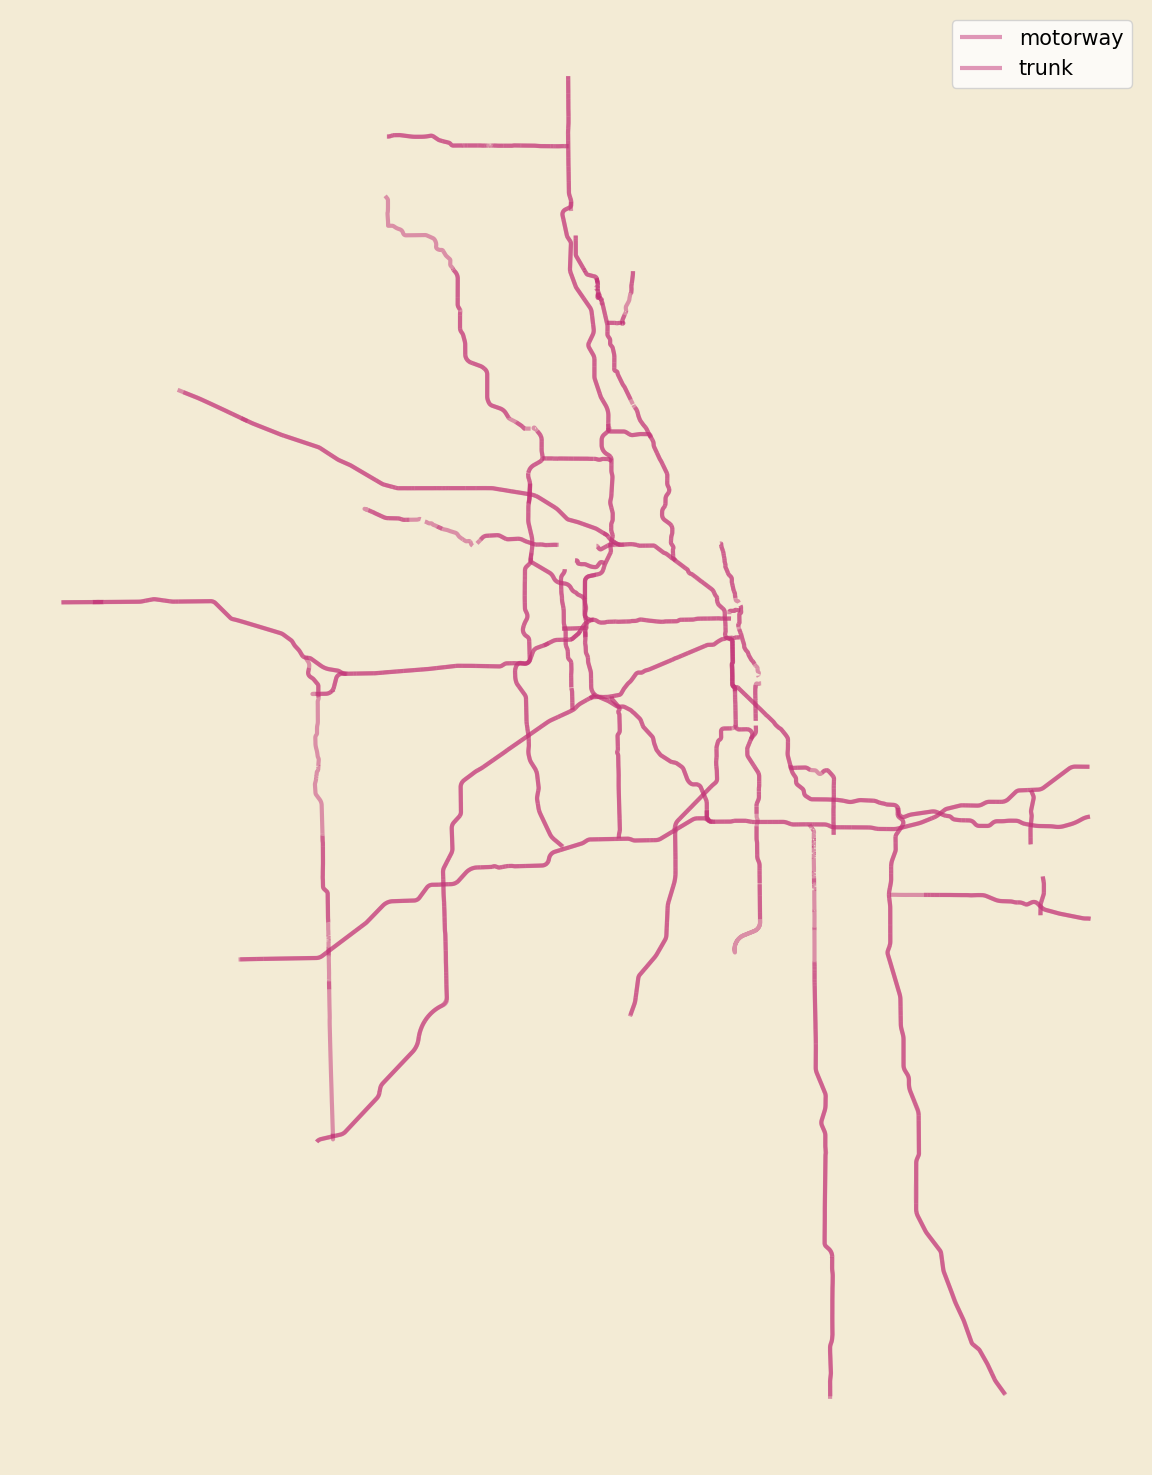

In [15]:
### Social-spatial intersection
plot_street_network(gdf_edges_city, cbsacode)

In [16]:
gdf_edges_city_copy = gdf_edges_city.copy()
gdf_edges_city = gdf_edges_city.reset_index()

In [17]:
if randomize_streets:

    print("randomizing streets")
    
    add_fields = ['u', 'v', 'key', 'osmid', 'maxspeed', 'oneway', 'reversed', 'length', 'lanes', 
                    'service', 'bridge', 'name', 'width', 'ref', 'access', 'tunnel', 'junction']
    
    # get the list of highway (motorway/trunk) street lengths
    gdf_edges_city_motorway = gdf_edges_city[gdf_edges_city['highway'].isin(motorway_osm_labels)]
    street_lengths = sorted(list(gdf_edges_city_motorway["length"]))
    
    # randomize streets
    random_streets, random_street_lengths = get_random_street_network(
        G, 
        G_igraph, 
        gdf_nodes_city, 
        street_lengths
        )
    
    gpd_random_streets = gpd.GeoDataFrame(
        random_streets, 
        columns=['geometry'], 
        geometry="geometry", 
        crs="epsg:4326")
    
    # set empty fields to match the structure of the original gdf_edges_city
    gpd_random_streets['highway'] = 'motorway'
    for f in add_fields:
        gpd_random_streets[f] = None
    
    print(f'original_length={sum(street_lengths)}, new_length={sum(gpd_random_streets["geometry"].length)}', flush=True)
    
    gdf_edges_city = gpd_random_streets.copy()

else:
    print("not randomizing streets")

not randomizing streets


In [18]:
gdf, gdf_null = intersect_social_and_street(gdf_edges, gdf_edges_null, gdf_edges_city)

In [19]:
# collate similar OSM street types
print('collating streets', flush=True)

gdf['highway'] = gdf.apply(
    lambda x: collate_street_types(
        x.highway, 
        motorway_osm_labels=motorway_osm_labels
        ), 
    axis = 1
)

gdf_null['highway'] = gdf_null.apply(
    lambda x: collate_street_types(
        x.highway, 
        motorway_osm_labels=motorway_osm_labels
        ), 
    axis = 1
)

print(f'({cbsacode}) - socio-spatial intersections: real={len(gdf)}, null={len(gdf_null)}', flush=True)
d = gdf[['user_id1', 'user_id2', f'distance_beeline_m', f'distance_walking_m', 'highway']]
d = d.groupby(['user_id1', 'user_id2', f'distance_beeline_m', f'distance_walking_m', 'highway']).size().unstack(fill_value=0)
d = d.reset_index()
d_null = gdf_null[['user_id1', 'user_id2', f'distance_beeline_m', f'distance_walking_m', 'highway']]
d_null = d_null.groupby(['user_id1', 'user_id2', f'distance_beeline_m', f'distance_walking_m', 'highway']).size().unstack(fill_value=0)
d_null = d_null.reset_index()

collating streets
(16980) - socio-spatial intersections: real=31281, null=29660


In [20]:
print('writing results', flush=True)

results = {'real': d, 'null': d_null}

if distance_type == 'walking':
    results_outfile_name = f'../results_walking/{cbsacode}_s{random_seed}'
else:    
    results_outfile_name = f'../results/{cbsacode}_s{random_seed}'

if randomize_streets:
    results_outfile_name+='_randstreet'

results_outfile_name += f'_results.pickle'

with open(results_outfile_name, 'wb') as fout:
    pickle.dump(results, fout)

print(f'{cbsacode} done!')

writing results
16980 done!


### Calculate Barrier Scores

In [21]:
binning_d = 500 #width of the social tie length bin (meters)
maxlength_m = 10000 #offset of the last bin to consider (meters)
street_type = 'motorway'

# get results of the real and null model
df_res = None
df_res_null = None
with open(f'../results/{cbsacode}_s{random_seed}_results.pickle','rb') as fin:
    results = pickle.load(fin)
    df_res = results['real']
    df_res_null = results['null']

# discount values by distance
df_res[f'{street_type}_per_km'] = (df_res[street_type] / df_res[f'distance_beeline_m']) * 1000
df_res_null[f'{street_type}_per_km'] = (df_res_null[street_type] / df_res_null[f'distance_beeline_m']) * 1000
df_res = df_res[['user_id1', 'user_id2', 'distance_beeline_m', 'motorway']]
df_res_null = df_res_null[['user_id1', 'user_id2', 'distance_beeline_m', 'motorway']]

# calculate the barrier score per bin
res_per_km = []
for rng in range(binning_d, maxlength_m+binning_d+1, binning_d):
    df_res_rng = df_res[df_res['distance_beeline_m'] <= rng] 
    df_res_rng_null = df_res_null[df_res_null['distance_beeline_m'] <= rng]
    tot_crossings_real = df_res_rng[f'{street_type}'].sum()
    tot_length_real = df_res_rng['distance_beeline_m'].sum()
    tot_crossings_null = df_res_rng_null[f'{street_type}'].sum()
    tot_length_null = df_res_rng_null['distance_beeline_m'].sum()
    per_km_real_grand_avg = (tot_crossings_real / tot_length_real) * 1000
    per_km_null_grand_avg = (tot_crossings_null / tot_length_null) * 1000
    barrier_score = (per_km_null_grand_avg-per_km_real_grand_avg)/(per_km_real_grand_avg)
    res_per_km.append([cbsacode, city_name, street_type, random_seed, 
                       rng-binning_d, barrier_score, per_km_real_grand_avg, 
                       per_km_null_grand_avg, tot_length_real, tot_length_null, 
                       tot_crossings_real, tot_crossings_null])
df_barrier_score = pd.DataFrame(res_per_km, columns=['cbsacode', 'city_name', 'street_type', 'random_seed', 
                                  'bin', 'barrier_score', 'crossings_per_km_real', 
                                  'crossings_per_km_null', 'tot_length_real', 'tot_length_null', 
                                  'tot_crossings_real', 'tot_crossings_null'])

# calculate the city-wide barrier score
barrier_score_city = df_barrier_score['barrier_score'].dropna().mean()
print(f'Barrier score for {city_name} = {barrier_score_city}')
df_barrier_score

Barrier score for Chicago = -0.2252318679547481


,cbsacode,city_name,street_type,random_seed,bin,barrier_score,crossings_per_km_real,crossings_per_km_null,tot_length_real,tot_length_null,tot_crossings_real,tot_crossings_null
0,16980,Chicago,motorway,42,0,NaN,NaN,NaN,0,0,0,0
1,16980,Chicago,motorway,42,500,NaN,NaN,NaN,0,0,0,0
2,16980,Chicago,motorway,42,1000,NaN,NaN,NaN,0,0,0,0
3,16980,Chicago,motorway,42,1500,NaN,NaN,NaN,0,0,0,0
4,16980,Chicago,motorway,42,2000,NaN,NaN,NaN,0,0,0,0
5,16980,Chicago,motorway,42,2500,NaN,NaN,NaN,0,0,0,0
6,16980,Chicago,motorway,42,3000,NaN,NaN,NaN,0,0,0,0
7,16980,Chicago,motorway,42,3500,NaN,NaN,NaN,0,0,0,0
8,16980,Chicago,motorway,42,4000,NaN,NaN,NaN,0,0,0,0
9,16980,Chicago,motorway,42,4500,NaN,NaN,NaN,0,0,0,0
